In [1]:
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
from torch.nn import Module, Parameter
from torch import FloatTensor
from scipy import signal
import numpy as np
from torchaudio import transforms
import matplotlib.pyplot as plt
import IPython.display as ipd
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os
from scipy import signal
import numpy as np
from pylab import *
import soundfile as sf
import matplotlib.pyplot as plt

# Declare Model

In [15]:
class FIRNN(Module):
    def __init__(self, n_input=1, n_output=1, kernel_size=80, n_channel=32):
        super(FIRNN, self).__init__()        
        self.conv_kz = kernel_size
        self.input_len = 512
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=kernel_size, stride=1)#, bias=False)
        self.nonlinear = nn.Tanh()
        self.bn1 = nn.BatchNorm1d(n_channel)

        self.fc1 = nn.Conv1d(n_channel, n_channel*2, kernel_size=1)#, bias=False) 
        self.fc2 = nn.Conv1d(n_channel*2, n_channel, kernel_size=1)#, bias=False)
        
        self.conv2 = nn.Conv1d(n_channel, n_output, kernel_size=kernel_size, stride=1)#, bias=False)
        
        self.mlp_layer = nn.Sequential(
            self.fc1 ,
            nn.Tanh(),
            self.fc2,
        )


    def forward(self, x):
        #print(x.shape)
        bs = x.shape[0]
        
        x = F.pad(x, (self.conv_kz-1, 0)) #pad on the left side
        x = self.conv1(x)
        x1 = x
        #print(x.shape) #bs*32*512
        
        x = self.nonlinear(self.bn1(x))
        #print(x.shape) # bs*32*512
        x2 = x

        #x = x.view(bs, -1)
        x = self.mlp_layer(x)
        #x = self.layers(x)
        #print(x.shape) #bs*32*512
        x3 = x
        
        x = F.pad(x, (self.conv_kz-1, 0))
        x = self.conv2(x)
        #print(x.shape) #bs*1*512

        return x


In [16]:
class DIIRDataSet(Dataset):
    def __init__(self, input, target, sequence_length):
        self.input = input
        self.target = target
        self._sequence_length = sequence_length
        self.input_sequence = self.wrap_to_sequences(self.input, self._sequence_length)
        self.target_sequence = self.wrap_to_sequences(self.target, self._sequence_length)
        self._len = self.input_sequence.shape[0]

    def __len__(self):
        return self._len

    def __getitem__(self, index):
        return {'input': self.input_sequence[index, :, :]
               ,'target': self.target_sequence[index, :, :]}

    def wrap_to_sequences(self, data, sequence_length):
        num_sequences = int(np.floor(data.shape[0] / sequence_length))
        print(num_sequences)
        truncated_data = data[0:(num_sequences * sequence_length)]
        wrapped_data = truncated_data.reshape((num_sequences, sequence_length, 1))
        wrapped_data = wrapped_data.permute(0,2,1)
        print(wrapped_data.shape)
        return np.float32(wrapped_data)

    

# Load Model

In [17]:
model = FIRNN(kernel_size=80, n_channel=32)

In [18]:
model_path = './models/model_firnl_mlp_fir_preamph_ep99.pth'#'./models/FIRNN_HT1_nobias_ep99.pth'# model_firnl_mlp_fir_preamph_ep99.pth'
model.load_state_dict(torch.load(model_path))
model.eval()

FIRNN(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(1,))
  (nonlinear): Tanh()
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
  (fc2): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(32, 1, kernel_size=(80,), stride=(1,))
  (mlp_layer): Sequential(
    (0): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
    (1): Tanh()
    (2): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
  )
)

## Test on a sinusoidal signal

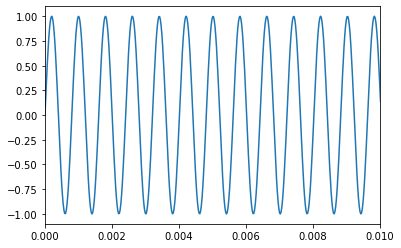

In [19]:
np.random.seed(0)
f = 1245

#dt = 0.01/f  # sampling interval
Fs = 44100 #f*10 #1 / dt  # sampling frequency
dt = 1/Fs
t = np.arange(0, 200, dt)

len(t)

dt

# generate noise:
# nse = np.random.randn(len(t))
# r = np.exp(-t / 0.05)
# cnse = np.convolve(nse, r) * dt
# cnse = cnse[:len(t)]

#s = 0.1 * np.sin(4 * np.pi * t) + cnse  # the signal

s = np.sin(2 * np.pi * f * t)

Fs

plt.plot(t,s)
plt.xlim(0,0.01)
plt.show()

In [20]:
sinput = torch.from_numpy(s).unsqueeze(0)

In [21]:
sinput.shape

torch.Size([1, 8820000])

In [22]:
val_dataset=DIIRDataSet(sinput.squeeze(0), sinput.squeeze(0), 512)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle = False, pin_memory=True, drop_last=True)

17226
torch.Size([17226, 1, 512])
17226
torch.Size([17226, 1, 512])


In [23]:
save_tensor = torch.zeros(17226,512)
with torch.no_grad():
    for i, val_batch in enumerate(val_loader):
        input_seq_batch = val_batch['input']
        predicted_output = model(input_seq_batch)
        output_tmp = predicted_output.squeeze().detach().cpu()
        #print(output_tmp.shape)
        save_tensor[i,:] = output_tmp

In [24]:
soutput = save_tensor.view(-1).numpy()#[0].numpy()#

In [25]:
soutput.shape

(8819712,)

## plot spectrum of the output from the model of a sinusoidal signal

In [ ]:
plt.figure(figsize=(8,10))
plt.subplot(4,1,1)
title("Raw sinusoidal signal", fontsize=20)
plt.magnitude_spectrum(s, Fs=Fs, color='C1')
plt.ylabel('Magnitude\n(energy)', fontsize=18)
plt.xlabel('Frequency (Hz)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)

plt.subplot(4,1,2)
title("Distorted sinusoidal signal", fontsize=20)
plt.magnitude_spectrum(soutput, Fs=Fs, color='C1')
plt.ylabel('Magnitude\n(energy)', fontsize=18)
plt.xlabel('Frequency (Hz)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylim(0.0, 0.7)

plt.subplot(4,1,3)
title("Distorted sinusoidal signal (dB)", fontsize=20)
plt.magnitude_spectrum(soutput[:5000], Fs=Fs, scale='dB', color='C1')
plt.ylabel('Magnitude (dB)', fontsize=18)
plt.xlabel('Frequency (Hz)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylim(-150, -10)

plt.subplot(4,1,4)
title("Distorted sinusoidal signal zoomed in (dB)", fontsize=20)
plt.magnitude_spectrum(soutput[:512], Fs=Fs, scale='dB', color='C1')
plt.ylabel('Magnitude (dB)', fontsize=18)
plt.xlabel('Frequency (Hz)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylim(-100,0)

plt.tight_layout()
subplots_adjust(hspace=0.7)
#plt.savefig('./figures/FIRNN_sin_signal_spectrums.png', dpi=150)
plt.show()

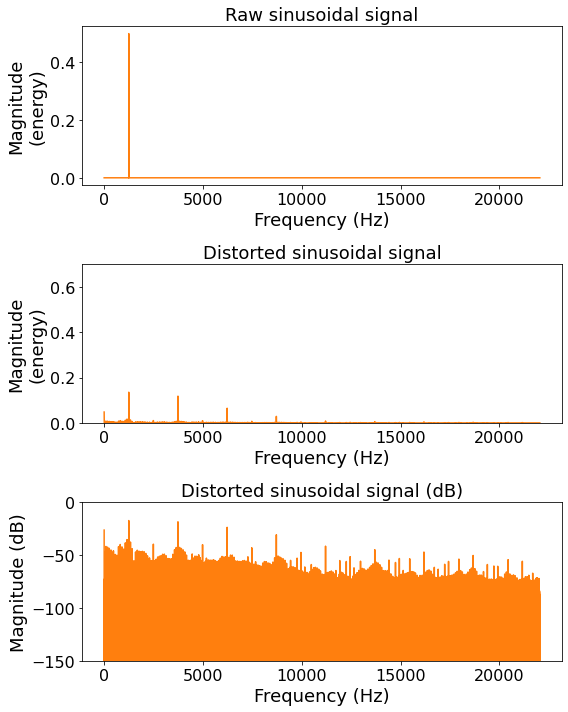

In [26]:
plt.figure(figsize=(8,10))
plt.subplot(3,1,1)
title("Raw sinusoidal signal", fontsize=18)
plt.magnitude_spectrum(s, Fs=Fs, color='C1')
plt.ylabel('Magnitude\n(energy)', fontsize=18)
plt.xlabel('Frequency (Hz)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)

plt.subplot(3,1,2)
title("Distorted sinusoidal signal", fontsize=18)
plt.magnitude_spectrum(soutput, Fs=Fs, color='C1')
plt.ylabel('Magnitude\n(energy)', fontsize=18)
plt.xlabel('Frequency (Hz)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylim(0.0, 0.7)

plt.subplot(3,1,3)
title("Distorted sinusoidal signal (dB)", fontsize=18)
plt.magnitude_spectrum(soutput, Fs=Fs, scale='dB', color='C1')
plt.ylabel('Magnitude (dB)', fontsize=18)
plt.xlabel('Frequency (Hz)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylim(-150, 0)

plt.tight_layout()
subplots_adjust(hspace=0.5)
#plt.savefig('./figures/FIRNN_nobias_sin_signal_spectrums.png', dpi=150)
plt.show()